
# **ACESSANDO OS DADOS DO ERA-5 VIA PROTOCOLO OPENDAP**
---

- ERA-5 `MENSAL`
1. Site: https://apdrc.soest.hawaii.edu/data/data.php?discipline_index=3
2. URLdos dados: http://apdrc.soest.hawaii.edu/dods/public_data/Reanalysis_Data/
3. Base de dados completa: https://apdrc.soest.hawaii.edu/dods/public_data/
4. Documentação: http://apdrc.soest.hawaii.edu/datadoc/ecmwf_ERA5.php

---

- Código realizado por: Enrique V. Mattos -- 14/04/2024 - enrique@unifei.edu.br


---

- Uma das grandes dificuldades em trabalhar com variáveis meteorológicas a nível global, é a necessidade de **baixar** e processar um grande volume de dados. O que muitas das vezes demanda um computador com um bom processamento e uma forte capacidade para armazenar esses dados.
- Para resolver esse problema, podemos acessar a base de dados disponibilizados em algum site ou FTP.
- Para isto o **Asia-Pacific Data Research Center** que é parte do International Pacific Research Center da **Universidade do Hawai** em Mānoa, financiado em parte pela the National Oceanic and Atmospheric Administration (NOAA) disponibiliza uma série de conjuntos de dados atmosféricos através do protocolo [**OPEnDAP**](http://apdrc.soest.hawaii.edu/data/data.php?discipline_index=3) como:

    1. [GPM IMERG L3 precipitation](http://apdrc.soest.hawaii.edu/dods/public_data/satellite_product/GPM_IMERG)

    2. [ECMWF ERA5](http://apdrc.soest.hawaii.edu/dods/public_data/Reanalysis_Data/ERA5)

    3. [LIS-OTD Lightning](http://apdrc.soest.hawaii.edu/dods/public_data/satellite_product/LIS-OTD-lightning-data)

    4. [CMIP5](http://apdrc.soest.hawaii.edu/dods/public_data/CMIP5/)

    5. E etc

* O `Xarray` permite acessar dados diretamente na nuvem em servidores que utilizam diretórios chamados de [**THREDDS Catalogs**](https://www.unidata.ucar.edu/software/tds/current/catalog/), com o uso do protocolo [**OPeNDAP**](https://earthdata.nasa.gov/collaborate/open-data-services-and-software/api/opendap).

- Para ler os dados direto da nuvem podemos utilizar a função [**open_dataset**](https://docs.xarray.dev/en/stable/generated/xarray.open_dataset.html) da biblioteca [xarray](https://docs.xarray.dev/en/stable/) do Python. Como exemplo, para ler dados de precipitação diária do IMERGE. Exemplo: ds = xr.open_dataset('http://apdrc.soest.hawaii.edu:80/dods/public_data/satellite_product/GPM_IMERG/daily').

- **Observação:** Uma segunda opção de site para acessar dados climáticos via protocolo OPeNDAP em formato, é através desse site da [**NOAA**](https://psl.noaa.gov/data/gridded/), como os dados de Temperatura da Superfície do Mar (ERSSTv5), Precipitação do GPCC e outros. Para acessar os dados de **Temperatura do Ar** da [**University of Delaware**](https://psl.noaa.gov/data/gridded/data.UDel_AirT_Precip.html) diretamente do servidor da NOAA através do seu link, que pode ser encontrado no [site acima](https://psl.noaa.gov/thredds/catalog/Datasets/catalog.html).

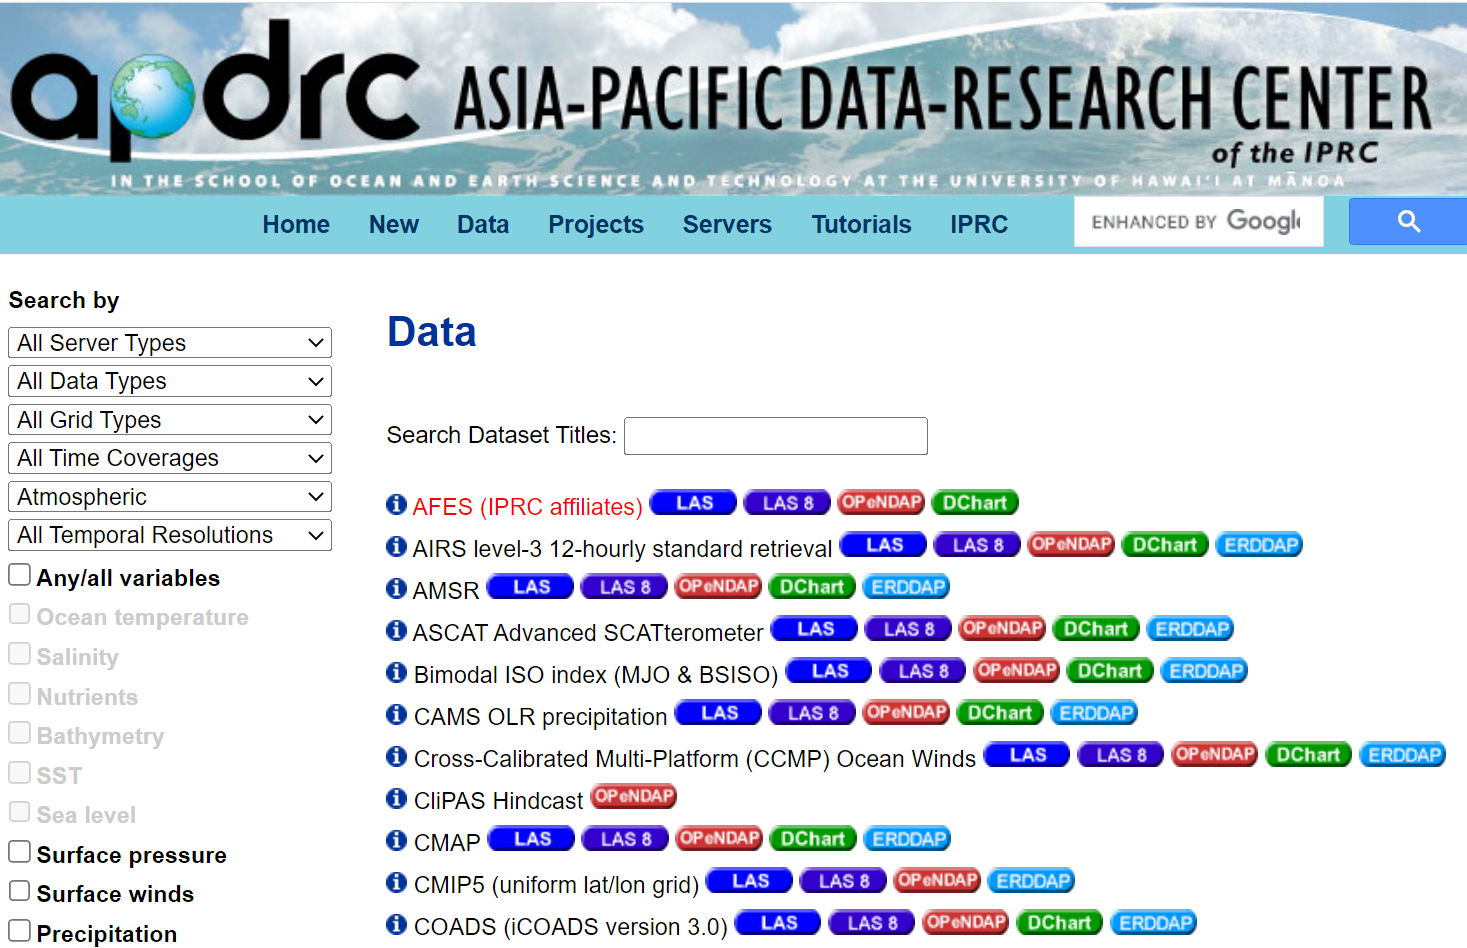

#Instalando bibliotecas

In [1]:
# Instalando matplotlib, proplot e numpy
!pip install -q matplotlib==3.4.3
!pip install -q proplot==0.9.7
!pip install -q numpy==1.24.3

# Instalando Xarray e suas dependências: https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
!pip install -q xarray dask netCDF4 bottleneck

# Instalando cartopy
!pip uninstall shapely --yes
!pip install -q shapely cartopy==0.21.1 --no-binary shapely --no-binary cartopy

Found existing installation: shapely 2.0.3
Uninstalling shapely-2.0.3:
  Successfully uninstalled shapely-2.0.3


- Chegando aqui, será necessário fazer a `Reinicialização do Ambiente de Execução`. Para isto, você deverá acessar `Ambiente de execução`, localizado na barra de ferramentas e clicar em `Reiniciar Sessão`. Como indicado na imagem abaixo.

- Em seguida você deverá rodar novamente a célula anterior de instalações, de forma que as bibliotecas sejam instaladas novamente.

- Isso é necessário tanto para poder usar sem problemas o `Proplot` quanto o `CartoPy` na nossa sessão do Colab. Então a partir desse ponto não teremos mais que nos preocupar com a preparação do ambiente virtual.

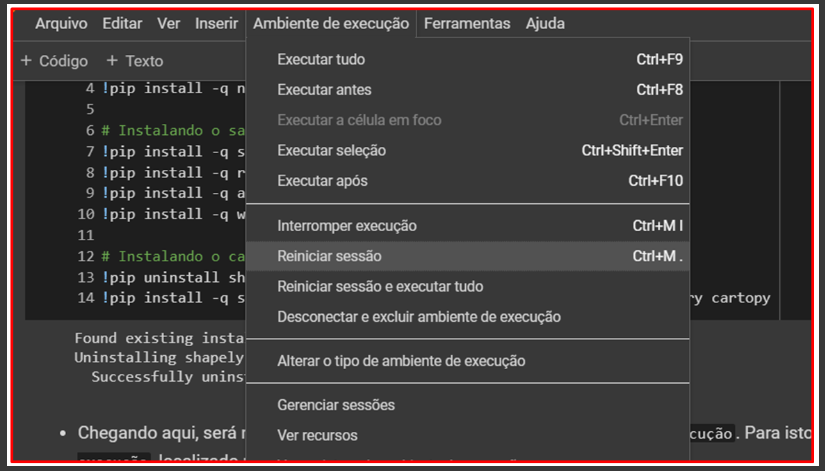

#Importando bibliotecas

In [2]:
import proplot as pplt
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
import xarray as xr
import matplotlib.pyplot as plt

# vamos ignorar avisos
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.10/dist-packages/proplot/__init__.py:71: ProplotWarning: Rebuilding font cache. This usually happens after installing or updating proplot.
  register_fonts(default=True)


#Plotando figura


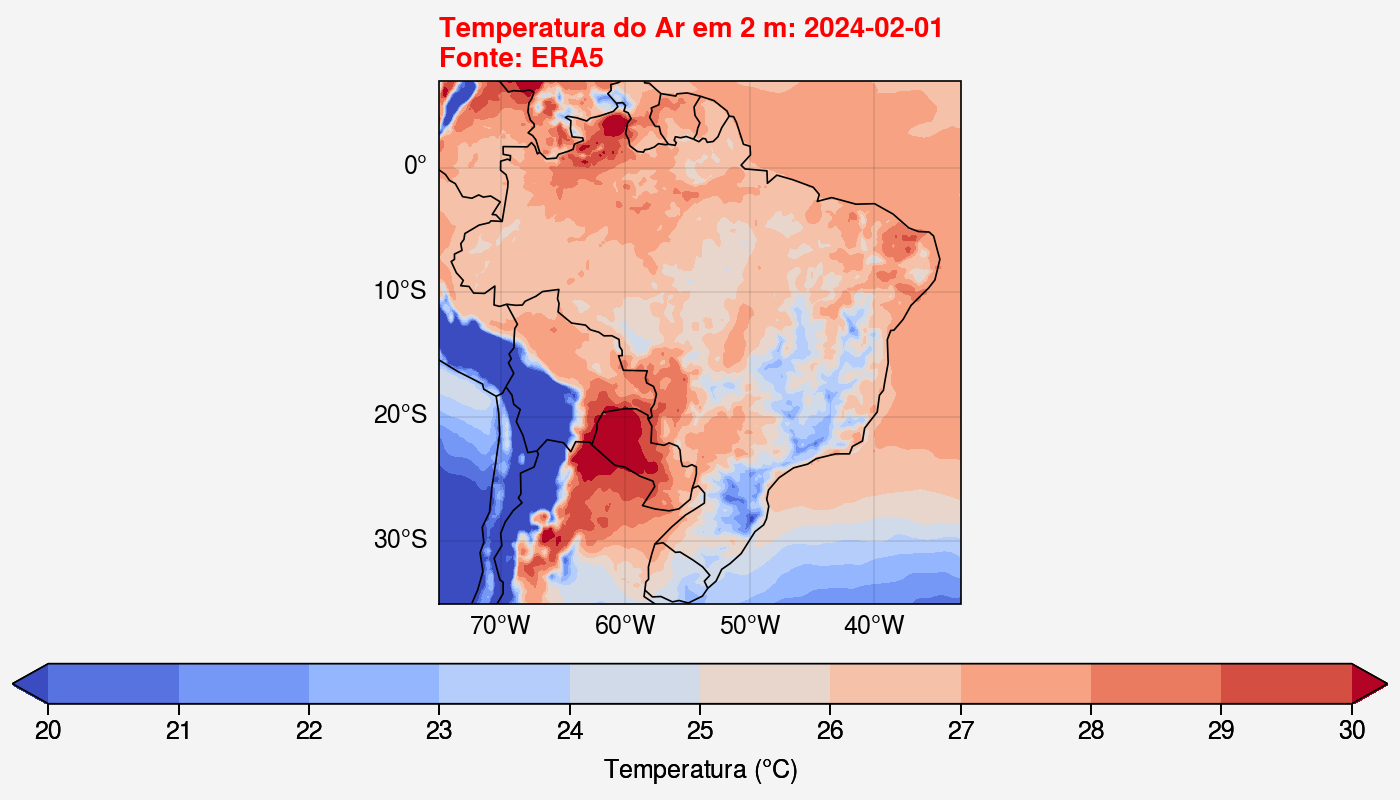

In [14]:
# limites do Brasil
lonmin, lonmax, latmin, latmax = -75.0, -33.0, -35.0, 7.0

# link dos dados
url = 'http://apdrc.soest.hawaii.edu:80/dods/public_data/Reanalysis_Data/'

# carrega os dados
era5_mensal = xr.open_dataset(url + 'ERA5/monthly_2d/Surface')

# transforma as longitudes de 0/360 para -180/+180
era5_mensal.coords['lon'] = ((era5_mensal.coords['lon'] + 180) % 360) - 180
era5_mensal = era5_mensal.sortby(era5_mensal.lon)

# seleciona os dados para o Brasil entre 1990 e 2024
era5_mensal_brasil = era5_mensal.sel(lon=slice(lonmin,lonmax), lat=slice(latmin,latmax)).sel(time=slice('1990-01-01','2024-12-01'))

# plota figura
fig, ax = pplt.subplots(figsize=(7, 4), tight=True, proj='pcarree')

ax.format(coast=True, borders=True, innerborders=False,
          labels=True, latlines=10, lonlines=10,
          latlim=(latmin, latmax), lonlim=(lonmin, lonmax),
          ltitle='Temperatura do Ar em 2 m: 2024-02-01\nFonte: ERA5',
          titleweight='bold', titlecolor='red')

map1 = ax.contourf(era5_mensal_brasil['lon'],
                   era5_mensal_brasil['lat'],
                   era5_mensal_brasil['t2m'].loc['2024-02-01']-273.15,
                   cmap='coolwarm',
                   levels=pplt.arange(20, 30, 1),
                   extend='both')

fig.colorbar(map1, loc='b', label='Temperatura ($\degree$C)')
pplt.show()

In [15]:
# mostra a base de dados que foi carregada
era5_mensal

<xarray.Dataset>
Dimensions:  (time: 1011, lat: 721, lon: 1440)
Coordinates:
  * time     (time) datetime64[ns] 1940-01-01 1940-02-01 ... 2024-03-01
  * lat      (lat) float64 -90.0 -89.75 -89.5 -89.25 ... 89.25 89.5 89.75 90.0
  * lon      (lon) float64 -180.0 -179.8 -179.5 -179.2 ... 179.2 179.5 179.8
Data variables:
    u10      (time, lat, lon) float32 ...
    v10      (time, lat, lon) float32 ...
    t2m      (time, lat, lon) float32 ...
    iews     (time, lat, lon) float32 ...
    inss     (time, lat, lon) float32 ...
    msl      (time, lat, lon) float32 ...
    skt      (time, lat, lon) float32 ...
    sp       (time, lat, lon) float32 ...
    sst      (time, lat, lon) float32 ...
    tp       (time, lat, lon) float32 ...
Attributes:
    title:          ERA5 monthly averaged reanalysis single level variables
    Conventions:    COARDS\nGrADS
    dataType:       Grid
    documentation:  http://apdrc.soest.hawaii.edu/datadoc/ecmwf_ERA5.php
    history:        Tue Apr 09 08:12:34 HST 2024 : imported by GrADS Data Ser...

In [16]:
# mostra os dados selecionados para o Brasil e período de 1990-2024
era5_mensal_brasil

<xarray.Dataset>
Dimensions:  (time: 411, lat: 169, lon: 169)
Coordinates:
  * time     (time) datetime64[ns] 1990-01-01 1990-02-01 ... 2024-03-01
  * lat      (lat) float64 -35.0 -34.75 -34.5 -34.25 -34.0 ... 6.25 6.5 6.75 7.0
  * lon      (lon) float64 -75.0 -74.75 -74.5 -74.25 ... -33.5 -33.25 -33.0
Data variables:
    u10      (time, lat, lon) float32 ...
    v10      (time, lat, lon) float32 ...
    t2m      (time, lat, lon) float32 ...
    iews     (time, lat, lon) float32 ...
    inss     (time, lat, lon) float32 ...
    msl      (time, lat, lon) float32 ...
    skt      (time, lat, lon) float32 ...
    sp       (time, lat, lon) float32 ...
    sst      (time, lat, lon) float32 ...
    tp       (time, lat, lon) float32 ...
Attributes:
    title:          ERA5 monthly averaged reanalysis single level variables
    Conventions:    COARDS\nGrADS
    dataType:       Grid
    documentation:  http://apdrc.soest.hawaii.edu/datadoc/ecmwf_ERA5.php
    history:        Tue Apr 09 08:12:34 HST 2024 : imported by GrADS Data Ser...